In [1]:
import time
%matplotlib inline
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.fftpack import fft
import krotov
import scipy
from jupyterthemes import jtplot
jtplot.style()
import os

In [2]:
class STIRAP():
    def __init__(self,Omega_S,Omega_P,E1,E2,E3,T,tS1,tS2,tP1,tP2,Δ=0,Gamma=0,delta=0,lam=0.1):
        self.Ω_S = Omega_S
        self.Ω_P = Omega_P
        self.E1 = E1
        self.E2 = E2
        self.E3 = E3
        self.T = T
        self.tS1 = tS1*T
        self.tS2 = tS2*T
        self.tP1 = tP1*T
        self.tP2 = tP2*T
        self.Δ = Δ - (1j*Gamma)
        self.efficiency = 0
        self.delta = delta
        self.lam = lam*min(Omega_S,Omega_P)
    
    def Omega_P1(self,t, args):
        return self.Ω_P*krotov.shapes.blackman(t, t_start=self.tP1, t_stop=self.tP2)

    def Omega_P2(self,t, args):
        return 0.0

    def Omega_S1(self,t, args):
        return self.Ω_S*krotov.shapes.blackman(t, t_start=self.tS1, t_stop=self.tS2)
    
    def Omega_S2(self,t, args):
        return 0.0
    
    def hamiltonian(self):
        # detunings
        ΔP = self.Δ #E1 + omega_P - E2
        ΔS = -ΔP + self.delta   #E3 + omega_S - E2
        H0 = Qobj([[0.0, 0.0, 0.0], [0.0,ΔP, 0.0], [0.0, 0.0,self.delta]])
        HP_re = 0.5 * Qobj([[0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
        HP_im = 0.5 * Qobj([[0.0, 1.0j, 0.0], [-1.0j, 0.0, 0.0], [0.0, 0.0, 0.0]])
        HS_re = 0.5 * Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0]])
        HS_im = 0.5 * Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0j], [0.0, -1.0j, 0.0]])
        return [H0,[HP_re, self.Omega_P1],[HP_im, self.Omega_P2],[HS_re, self.Omega_S1],[HS_im, self.Omega_S2],]
    
    def final_result(self):
        kets = [qutip.Qobj(np.array([float(i is j) for j in range(3)])) for i in range(3)]
        psi_target = np.exp(1j * (self.E3 + self.Δ) * self.T) * kets[2]
        objective = krotov.Objective(initial_state=kets[0], target=psi_target, H=self.hamiltonian())
        tlist = np.linspace(0, self.T, 500)
        result = objective.mesolve(tlist, e_ops=[qutip.ket2dm(ket) for ket in kets])
        self.efficiency = result.expect[2][-1]
        return result,self.efficiency
    
        
    def final_plot(self):
        result,_ = self.final_result()
        fig, ax = plt.subplots()
        ax.plot(result.times, result.expect[0], label='1')
        ax.plot(result.times, result.expect[1], label='2')
        ax.plot(result.times, result.expect[2], label='3')
        ax.legend()
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        plt.show(fig)
    
    def plot_pulse(self):
        tlist = np.linspace(0, self.T, 500)
        pulse = tlist
        if callable(self.Omega_P1) and callable(self.Omega_S1):
            pulse1 = np.array([self.Omega_P1(t, args=None) for t in tlist])
            pulse2 = np.array([self.Omega_S1(t, args=None) for t in tlist])
        plt.plot(tlist, pulse1,label="Pump")
        plt.plot(tlist, pulse2,label="Stokes")
        plt.xlabel('Time')
        plt.ylabel('Pulse amplitude')
        plt.legend()
        plt.show()
        
    def S(self,t):
        return krotov.shapes.flattop(t, t_start=0.0, t_stop=self.T, t_rise=self.T*0.05, func='blackman')
    
    def plot_pulse_amplitude_and_phase(self,pulse_real, pulse_imaginary,tlist):
        ax1 = plt.subplot(211)
        ax2 = plt.subplot(212)
        amplitudes = [np.sqrt(x*x + y*y) for x,y in zip(pulse_real,pulse_imaginary)]
        phases = [np.arctan2(y,x)/np.pi for x,y in zip(pulse_real,pulse_imaginary)]
        ax1.plot(tlist,amplitudes)
        ax1.set_xlabel('time')
        ax1.set_ylabel('pulse amplitude')
        ax2.plot(tlist,phases)
        ax2.set_xlabel('time')
        ax2.set_ylabel('pulse phase (π)')
        plt.show()
    
    def plot_physical_field(self,pulse_re, pulse_im, tlist, case=None):
        tlist = np.linspace(0, self.T, 500)
        if case == 'pump':
            w = self.E2 - self.E1 + self.Δ
        elif case == 'stokes':
            w = self.E3 - self.E2 - self.Δ + self.delta
        else:
            print('Error: selected case is not a valid option')
            return
        ax = plt.subplot(111)
        ax.plot(tlist,pulse_re*np.cos(w*tlist)-pulse_im*np.sin(w*tlist), 'r')
        ax.set_xlabel('time', fontsize = 16)
        if case == 'pump':
            ax.set_ylabel(r'$\mu_{12}\,\epsilon_{P}$')
        elif case == 'stokes':
            ax.set_ylabel(r'$ \mu_{23}\,\epsilon_{S}$')
        plt.show()

    
    def optimization_routine(self):
        tlist = np.linspace(0, self.T, 500)
        H = self.hamiltonian()
        pulse_options = {
            H[1][1]: dict(lambda_a=self.lam, update_shape=self.S),
            H[2][1]: dict(lambda_a=self.lam, update_shape=self.S),
            H[3][1]: dict(lambda_a=self.lam, update_shape=self.S),
            H[4][1]: dict(lambda_a=self.lam, update_shape=self.S)
        }
        kets = [qutip.Qobj(np.array([float(i is j) for j in range(3)])) for i in range(3)]
        psi_target = np.exp(1j * (self.E3 + self.Δ) * self.T) * kets[2]
        objective = krotov.Objective(initial_state=kets[0], target=psi_target, H=self.hamiltonian())
        opt_result = krotov.optimize_pulses(
            [objective],
            pulse_options,
            tlist,
            propagator=krotov.propagators.expm,
            chi_constructor=krotov.functionals.chis_re,
            info_hook=krotov.info_hooks.print_table(
                J_T=krotov.functionals.J_T_re,
                show_g_a_int_per_pulse=True,
                unicode=False,
            ),
            check_convergence=krotov.convergence.Or(
                krotov.convergence.value_below(1e-3, name='J_T'),
                krotov.convergence.delta_below(1e-5),
                krotov.convergence.check_monotonic_error,
            ),
            iter_stop=15,
        )
        if not os.path.isfile('lambda_rwa_opt_result.dump'):
            opt_result.dump('lambda_rwa_opt_result.dump')
        return opt_result
    
    def print_opti_pulse(self):
        opt_result = self.optimization_routine()
        tlist = np.linspace(0, self.T, 500)
        print("pump pulse amplitude and phase:")
        self.plot_pulse_amplitude_and_phase(opt_result.optimized_controls[0], opt_result.optimized_controls[1], tlist)
        print("Stokes pulse amplitude and phase:")
        self.plot_pulse_amplitude_and_phase(opt_result.optimized_controls[2], opt_result.optimized_controls[3], tlist)
#         print('Physical electric pump pulse in the lab frame:')
#         self.plot_physical_field(opt_result.optimized_controls[0], opt_result.optimized_controls[1], tlist, case = 'pump')
#         print('Physical electric Stokes pulse in the lab frame:')
#         self.plot_physical_field(opt_result.optimized_controls[2], opt_result.optimized_controls[3], tlist, case = 'stokes')
        
    def final_opti_rest(self):
        kets = [qutip.Qobj(np.array([float(i is j) for j in range(3)])) for i in range(3)]
        tlist = np.linspace(0, self.T, 500)
        result = self.optimization_routine().optimized_objectives[0].mesolve(tlist, e_ops=[qutip.ket2dm(ket) for ket in kets])
        fig, ax = plt.subplots()
        ax.plot(result.times, result.expect[0], label='1')
        ax.plot(result.times, result.expect[1], label='2')
        ax.plot(result.times, result.expect[2], label='3')
        ax.legend()
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        plt.show(fig)

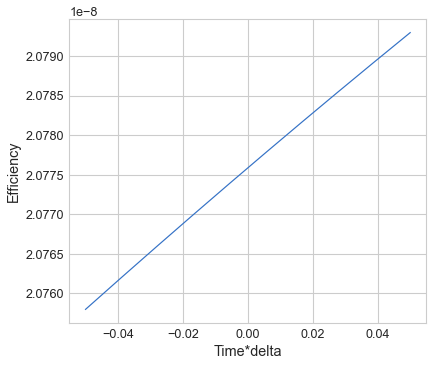

In [3]:

T=5*10**(-8)
deltavalues=np.linspace(-10**6, 10**6, 10)
h = 6.626*(10**(-34))
hfs = 6.834673617*(10**9)
F_3 = 3.845*(10**14)
xvalues=T*deltavalues
yvalues=[]
for i in deltavalues:
    trial=STIRAP(Omega_S=31.6*10**6,Omega_P=31.6*10**5,E1=0,E2=hfs,E3=F_3,T=5*10**(-8),tS1=0,tS2=0.8,tP1=0.2,tP2=1,Δ=1.2*10**9,Gamma=6*10**6,delta=i)
    _,e = trial.final_result()
    #Guesses
    
    yvalues.append(e)

fig, ax = plt.subplots()
ax.plot(xvalues, yvalues)
ax.set_xlabel('Time*delta')
ax.set_ylabel('Efficiency')
plt.show(fig)
    
    

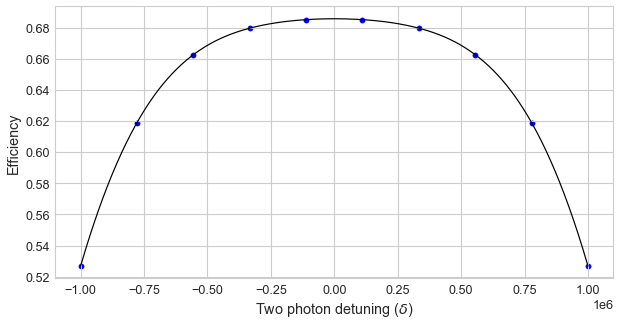

In [20]:
#Δ=0
T=5*10**(-5)
deltavalues=np.linspace(-10**6, 10**6, 10)
h = 6.626*(10**(-34))
hfs = 6.834673617*(10**9)
F_3 = 3.845*(10**14)
xvalues=deltavalues
yvalues=[]
for i in deltavalues:
    trial=STIRAP(Omega_S=31.6*10**6,Omega_P=31.6*10**5,E1=0,E2=hfs,E3=F_3,T=5*10**(-5),tS1=0,tS2=0.8,tP1=0.2,tP2=1,Δ=0,Gamma=6*10**6,delta=i)
    _,e = trial.final_result()
    yvalues.append(e)


def eff_interpolated(x,V,C):
    x_points = V
    y_points = C
    tck = scipy.interpolate.splrep(x_points, y_points)
    return scipy.interpolate.splev(x, tck)
deltax=np.linspace(-10**6, 10**6, 1000)
efficiency=eff_interpolated(deltax,xvalues,yvalues)
fig, ax = plt.subplots()

ax.set_xlabel('Two photon detuning ($\delta$)')
ax.set_ylabel('Efficiency')
fig.set_figwidth(10)
fig.set_figheight(5)
ax.plot(deltax, efficiency, color="black")
ax.scatter(xvalues, yvalues, color="blue")
plt.show(fig)

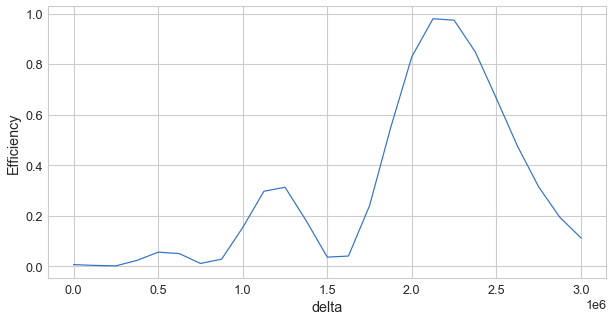

In [16]:
T=25*10**(-6)
deltavalues=np.linspace(0, 3*10**6, 25)
h = 6.626*(10**(-34))
hfs = 6.834673617*(10**9)
F_3 = 3.845*(10**14)
xvalues=deltavalues
yvalues=[]
for i in deltavalues:
    trial=STIRAP(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=25*10**(-6),tS1=0,tS2=1.2,tP1=0.16,tP2=1,Δ=10**9,Gamma=0,delta=i)
    _,e = trial.final_result()
    yvalues.append(e)

fig, ax = plt.subplots()

ax.set_xlabel('delta')
ax.set_ylabel('Efficiency')
fig.set_figwidth(10)
fig.set_figheight(5)
ax.plot(xvalues, yvalues)
plt.show(fig)

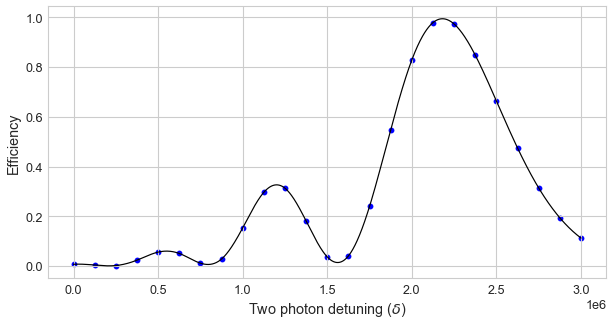

In [18]:
def eff_interpolated(x,V,C):
    x_points = V
    y_points = C
    tck = scipy.interpolate.splrep(x_points, y_points)
    return scipy.interpolate.splev(x, tck)
deltax=np.linspace(0, 3*10**6, 1000)
efficiency=eff_interpolated(deltax,xvalues,yvalues)
fig, ax = plt.subplots()

ax.set_xlabel('Two photon detuning ($\delta$)')
ax.set_ylabel('Efficiency')
fig.set_figwidth(10)
fig.set_figheight(5)
ax.plot(deltax, efficiency, color="black")
ax.scatter(xvalues, yvalues, color="blue")
plt.show(fig)

      fun: -3.258448112200981e-08
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.19981983e-07,  2.13944259e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.8 , 0.14])
      fun: -3.259044671033472e-08
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.20030901e-07,  2.13976479e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.8 , 0.14])
      fun: -3.25963420804091e-08
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.20078534e-07,  2.14008369e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.8 , 0.14])
      fun: -3.260216719393567e-08
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float

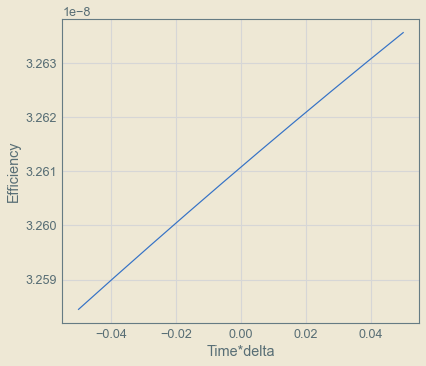

In [6]:
#TΔ=60
#for unequal pusle sizes
T=5*10**(-8)
deltavalues=np.linspace(-10**6, 10**6, 10)
h = 6.626*(10**(-34))
hfs = 6.834673617*(10**9)
F_3 = 3.845*(10**14)
xvalues=T*deltavalues
yvalues=[]
for i in deltavalues:
    t1 = time.time()
    def eff(x):
        trial=STIRAP(Omega_S=31.6*10**6,Omega_P=31.6*10**5,E1=0,E2=hfs,E3=F_3,T=5*10**(-8),tS1=0,tS2=x[0],tP1=x[1],tP2=1,Δ=1.2*10**9,Gamma=6*10**6,delta=i)
        _,e = trial.final_result()
        return -e
    delta = 2*10**6
    tS2 = 0.8
    tP1 = 0.14
    tP2 = 0.9
    learning_rate = 0.05
    opti = scipy.optimize.minimize(eff, x0=np.array([tS2,tP1]), args=(),bounds = [(0.8,0.9),(0,0.2)], options={"maxiter":10,"disp":True})
    print(opti)
    trial = STIRAP(Omega_S=31.6*10**6,Omega_P=31.6*10**5,E1=0,E2=hfs,E3=F_3,T=5*10**(-8),tS1=0,tS2=opti.x[0],tP1=opti.x[1],tP2=1,Δ=1.2*10**9,Gamma=6*10**6,delta=i,lam=0.1)
    _,efficiency = trial.final_result()
    #Guesses
    
    yvalues.append(efficiency)

fig, ax = plt.subplots()
ax.plot(xvalues, yvalues)
ax.set_xlabel('Time*delta')
ax.set_ylabel('Efficiency')
plt.show(fig)


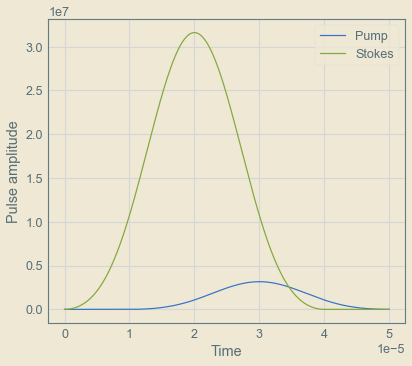

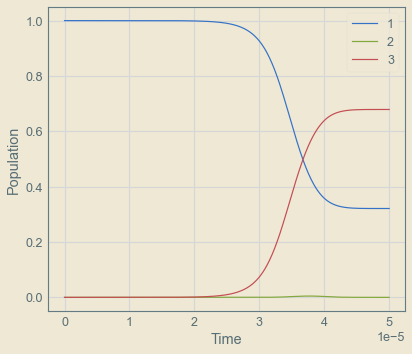

In [27]:
trial = STIRAP(Omega_S=31.6*10**6,Omega_P=31.6*10**5,E1=0,E2=hfs,E3=F_3,T=5*10**(-5),tS1=0,tS2=opti.x[0],tP1=opti.x[1],tP2=1,Δ=1.2*10**6,Gamma=6*10**6,delta=10**4,lam=0.1)
trial.plot_pulse()
trial.final_plot()

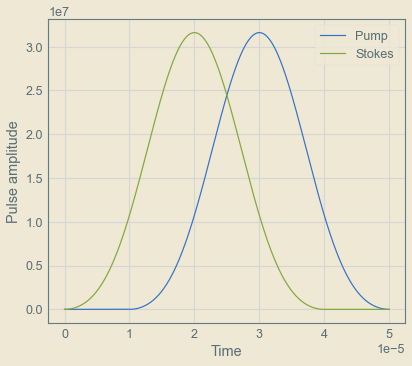

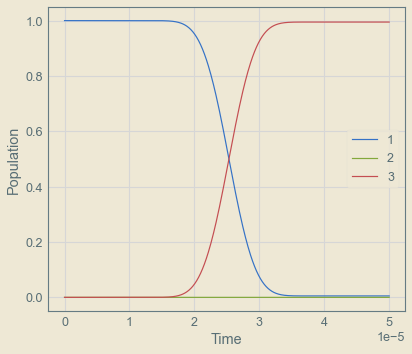

In [9]:
#Taking both as 31.6 MHz we can get effective rabi of approx 0.5 MHz with 1 GHz detuning
h = 6.626*(10**(-34))
hfs = 6.834673617*(10**9)
F_3 = 3.845*(10**14)
try_1 = STIRAP(Omega_S=31.6*10**6,Omega_P=31.6*10**6,E1=0,E2=hfs,E3=F_3,T=5*10**(-5),tS1=0,tS2=0.8,tP1=0.2,tP2=1,Δ=10**9,Gamma=6*10**6)
try_1.plot_pulse()
try_1.final_plot()

In [ ]:
#Guesses
t1 = time.time()
def eff(x):
    trial = STIRAP(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=5*10**(-5),tS1=0,tS2=x[0],tP1=x[1],tP2=1,Δ=10**9,Gamma=0*6*10**6,delta=2.088*10**6)
    _,e = trial.final_result()
    return -e
delta = 2*10**6
tS2 = 0.8
tP1 = 0.14
tP2 = 0.9
learning_rate = 0.05
opti = scipy.optimize.minimize(eff, x0=np.array([tS2,tP1]), args=(),bounds = [(0.8,0.9),(0,0.2)], options={"maxiter":10,"disp":True})
print(opti)

In [39]:
#Super inefficient

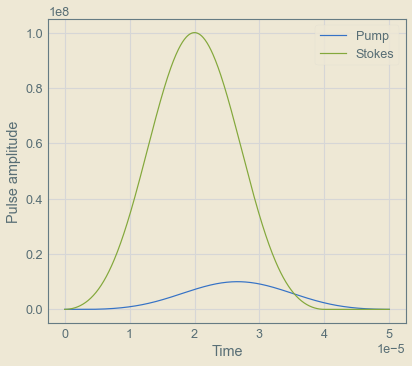

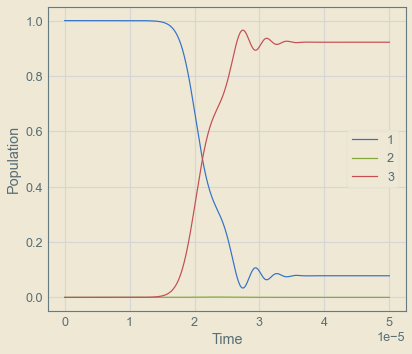

In [40]:
try_2 = STIRAP(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=5*10**(-5),tS1=0,tS2=opti.x[0],tP1=opti.x[1],tP2=1,Δ=10**9,Gamma=6*10**6,delta=2.088*10**6,lam=0.1)
try_2.plot_pulse()
try_2.final_plot()

In [41]:
t2 = time.time()
print(t2-t1)

7397.306729793549


      fun: -0.935807155342267
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([7.03873732, 6.52888823])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 342
      nit: 10
   status: 1
  success: False
        x: array([0.8       , 0.06452954])


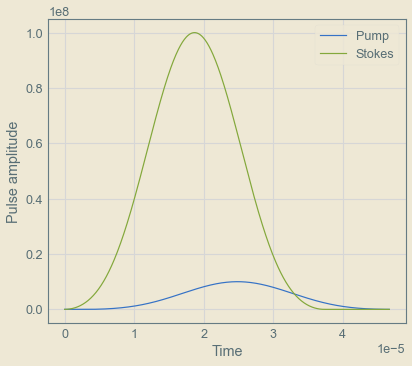

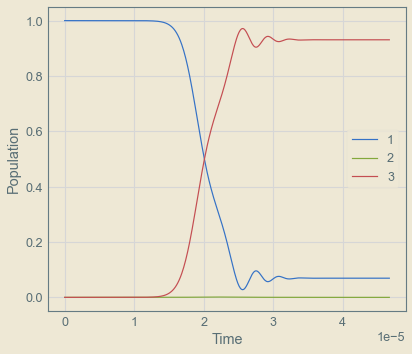

In [47]:
#Guesses
def eff(x):
    trial = STIRAP(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=x[0]*10**(-5),tS1=0,tS2=opti.x[0],tP1=opti.x[1],tP2=1,Δ=10**9,Gamma=6*10**6,delta=2.088*10**6,lam=0.1)
    _,e = trial.final_result()
    return -e
opti_T = scipy.optimize.minimize(eff, x0=np.array([5]), args=(),bounds = [(4,6)], options={"maxiter":10,"disp":True})
try_3 = STIRAP(Omega_S=100*10**6,Omega_P=10*10**6,E1=0,E2=hfs,E3=F_3,T=opti_T.x[0]*10**(-5),tS1=0,tS2=opti.x[0],tP1=opti.x[1],tP2=1,Δ=10**9,Gamma=6*10**6,delta=2.088*10**6,lam=0.1)
try_3.plot_pulse()
try_3.final_plot()

In [48]:
print(opti_T)

      fun: -0.9307177247612013
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.46969857])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 116
      nit: 6
   status: 0
  success: True
        x: array([4.67008038])


In [ ]:
#TΔ=60
#for unequal pusle sizes
T=5*10**(-8)
deltavalues=np.linspace(-10**6, 10**6, 10)
h = 6.626*(10**(-34))
hfs = 6.834673617*(10**9)
F_3 = 3.845*(10**14)
xvalues=T*deltavalues
yvalues=[]
for i in deltavalues:
    t1 = time.time()
    def eff(x):
        trial=STIRAP(Omega_S=31.6*10**6,Omega_P=31.6*10**5,E1=0,E2=hfs,E3=F_3,T=5*10**(-8),tS1=0,tS2=x[0],tP1=x[1],tP2=1,Δ=1.2*10**9,Gamma=0,delta=i)
        _,e = trial.final_result()
        return -e
    delta = 2*10**6
    tS2 = 0.8
    tP1 = 0.14
    tP2 = 0.9
    learning_rate = 0.05
    opti = scipy.optimize.minimize(eff, x0=np.array([tS2,tP1]), args=(),bounds = [(0.8,0.9),(0,0.2)], options={"maxiter":10,"disp":True})
    print(opti)
    trial = STIRAP(Omega_S=31.6*10**6,Omega_P=31.6*10**5,E1=0,E2=hfs,E3=F_3,T=5*10**(-8),tS1=0,tS2=opti.x[0],tP1=opti.x[1],tP2=1,Δ=1.2*10**9,Gamma=6*10**6,delta=i,lam=0.1)
    _,efficiency = trial.final_result()
    #Guesses
    
    yvalues.append(efficiency)

fig, ax = plt.subplots()
ax.plot(xvalues, yvalues)
ax.set_xlabel('Time*delta')
ax.set_ylabel('Efficiency')
plt.show(fig)
